<!--NAVIGATION-->
< [Design Spaces](01.01-Design-Space-Basics.ipynb) | [Contents](Index.ipynb) | [Results From Parametric Analysis](01.03-Results-From-Parametric-Analysis.ipynb) >

# Making a Sensitivity Analysis

In this chapter, we are taking what we learned about design spaces in the previous chapter, and are going to create a sensitivity analysis for an EnergyPlus model. This process is as follows: first, we take a building energy model, second we prepare a design space which will modify parameters of the model, third we prepare a Job to be run on Amazon Web Services.

Users of this library must be authenticated to use the APIClient. This way, communications with AWS services can only be done by authorized personel and costs can be tracked to users and projects. Authentication is done through an api_key that will be assigned to you.

The standard way to authenticate yourself for the duration of your session in a Jupyter Notebook is to add a block of code as follows. The call to `whoami` returns the username if the authentication is successfull.

In [1]:
import warnings

from surrogate_schema import APIClient

%load_ext dotenv
%dotenv

warnings.simplefilter(action="ignore", category=FutureWarning)


# typical block to authenticate to the API
client = APIClient()
client.whoami()  # shows that you are properly authenticated

User(username='sam@carbonsignal.com', email='sam@carbonsignal.com', full_name='Samuel Letellier-Duchesne', disabled=None, valid_until=datetime.datetime(2025, 6, 11, 15, 44, 24))

In [2]:
from archetypal import IDF

idf = IDF("data/seed_file_V960.idf")

## Making sure the model is compatible with the workflow

There are a couple things to check to make sure that the model you are working with is compatible with the workflow. First of all, the geometry definition of each thermal zone must be in "World Coordinates". Sometimes, models produced by OpenStudio will generate an IDF model with Zones that are defined in "Relative Coordinates". This means that the vertices defining the walls, windows, overhangs, etc. are defined relative to the Zone origin. The Zone itself can then have X Orgin, Y Origin and Z Origin values that place it in 3D space:

In [3]:
idf.idfobjects["ZONE"][0]


Zone,
    zone_5,                   !- Name
    ,                         !- Direction of Relative North
    ,                         !- X Origin
    ,                         !- Y Origin
    ,                         !- Z Origin
    ,                         !- Type
    ,                         !- Multiplier
    ,                         !- Ceiling Height
    ,                         !- Volume
    ,                         !- Floor Area
    ,                         !- Zone Inside Convection Algorithm
    ;                         !- Zone Outside Convection Algorithm

When that is the case, the model needs to be "translated" to "World Coordinates" such that each vertices is relative to the origin (0,0,0). Fortunately, `archetypal` has a function that can do that automatically: the `IDF.to_world()` method.

In [4]:
idf.to_world()

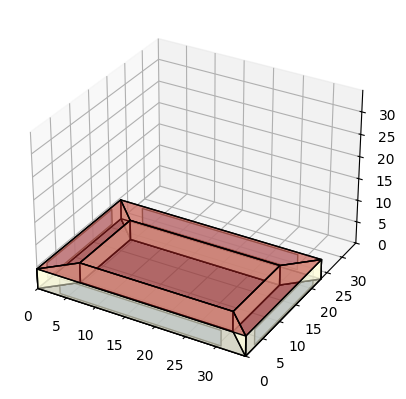

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [5]:
idf.view_model()

In [6]:
from surrogate_schema import BuildingAnalysis

A BuildingAnalysis class holds all the relevant information regarding a sensitivity analyis (as well as a parametric analysis, but that will come next)

In [7]:
from surrogate_schema import Space
from surrogate_schema.space.design_space import Dimension

In [8]:
space = Space(
    dimensions=[
        Dimension(name="WINU", categories=[0.14, 0.3, 0.4, 0.5, 0.8]),
        Dimension(name="WWR", categories=[0.1, 0.3, 0.5, 0.7, 0.9]),
    ],
)

In [9]:
analysis = BuildingAnalysis(
    company="Elementa",
    project="Tutorial",
    local_epw="data/USA_CA_Chino.AP.722899_TMYx.epw",
    local_seed_model="data/seed_file_V960.idf",
    design_space=space,
    baseline={"WINU": 0.4, "WWR": 0.5},
)

analysis

BuildingAnalysis(analysis_id=UUID('1c06bf42-d312-48c8-ac91-6f942da7f1b7'), company='Elementa', project='Tutorial', local_epw=PosixPath('data/USA_CA_Chino.AP.722899_TMYx.epw'), local_seed_model=PosixPath('data/seed_file_V960.idf'), local_template=None, hvac_template_name=None, hvac_template_zone_scheme=<SystemScheme.SINGLE_SYSTEM: 1>, local_iddname=None, local_ddyname=None, seed_model_s3_path=None, template_s3_path=None, epw_s3_path=None, iddname_s3_path=None, ddyname_s3_path=None, job=[], job_response=[], design_space=Space(dimensions=[Dimension(name='WINU', categories=[0.14, 0.3, 0.4, 0.5, 0.8], low=None, high=None, baseline=None, base=10, transformer=None, prior=None, dtype=dtype('float64'), practical_ranges={'Passive House': 0.14, 'Single Pane': 1.02, 'Double, clear': 0.5, 'Double, low-e': 0.352}), Dimension(name='WWR', categories=[0.1, 0.3, 0.5, 0.7, 0.9], low=None, high=None, baseline=None, base=10, transformer=None, prior=None, dtype=dtype('float64'), practical_ranges=None)], spa

In [10]:
analysis.create_space().to_df()

,WINU,WWR
0,0.14,0.1
1,0.14,0.3
2,0.14,0.5
3,0.14,0.7
4,0.14,0.9
5,0.30,0.1
6,0.30,0.3
7,0.30,0.5
8,0.30,0.7
9,0.30,0.9


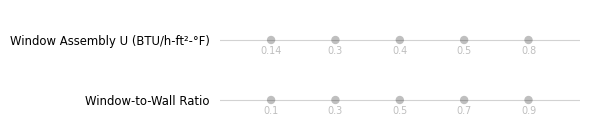

In [11]:
fig, ax = analysis.sampled_space.pretty_bubble_chart()

In [12]:
analysis.local_epw

PosixPath('data/USA_CA_Chino.AP.722899_TMYx.epw')

In [13]:
str(analysis.epw_s3_path)

'None'

In [14]:
analysis.seed_model_s3_path

In [15]:
analysis.seed_model_s3_path = None

In [16]:
analysis.prepare_job()

[GenerateAndRunJob(parameters=Parameters(log_level=<LogLevel.INFO: 'INFO'>, run_number=None, parameters=Url('s3://surrogate-api/parametric/1c06bf42-d312-48c8-ac91-6f942da7f1b7/parameters.json'), prototype_model=Url('s3://surrogate-api/parametric/1c06bf42-d312-48c8-ac91-6f942da7f1b7/seed_file_V960.idf'), form_factor=None, template_library=None, ddy_file=None, idf_output_dir=Url('s3://surrogate-api/parametric/1c06bf42-d312-48c8-ac91-6f942da7f1b7/idfs/'), output_meters=None, output_variables=None, include=None, table_name='single-building-analysis', start_index='0', reporting_frequency='Monthly', upload_to_s3=False), jobName='parametric_1c06bf42-d312-48c8-ac91-6f942da7f1b7', jobQueue='dev', arrayProperties=ArrayProperty(size=25), tags={'Project': 'Tutorial', 'Company': 'Elementa', 'SubmittedBy': 'sam@carbonsignal_com'}, propagateTags=True, containerOverrides=ContainerOverrides(command=['--log-level', 'Ref::log_level', 'generate-idf-and-run', '--parameters', 'Ref::parameters', '--idf-outpu

In [17]:
analysis.submit_job()

[SubmitJobResponse(jobArn='arn:aws:batch:us-east-2:664685589714:job/acafc4bb-7d2e-4565-8461-aa70b620efcd', jobName='parametric_1c06bf42-d312-48c8-ac91-6f942da7f1b7', jobId=UUID('acafc4bb-7d2e-4565-8461-aa70b620efcd'))]

In [18]:
analysis.track_status()

0it [00:00, ?it/s]

In [19]:
with open("data/analysis.json", "w") as f:
    f.write(analysis.model_dump_json())

<!--NAVIGATION-->
< [Design Spaces](01.01-Design-Space-Basics.ipynb) | [Contents](Index.ipynb) | [Results From Parametric Analysis](01.03-Results-From-Parametric-Analysis.ipynb) >